In [19]:
#Upload + Unzip

from google.colab import files
uploaded = files.upload()

import zipfile, os

os.makedirs("data", exist_ok=True)

# Unzip into /content/data
for fn in uploaded.keys():
    with zipfile.ZipFile(fn, 'r') as z:
        z.extractall("data")

print("=== Folder Structure ===")
for root, dirs, files in os.walk("data"):
    print(root, "-> DIRS:", dirs, "FILES:", files[:5])


Saving New_Dataset_CNN.zip to New_Dataset_CNN (1).zip
=== Folder Structure ===
data -> DIRS: ['New_Dataset'] FILES: []
data/New_Dataset -> DIRS: ['sea', 'forest', 'buildings', 'glacier'] FILES: []
data/New_Dataset/sea -> DIRS: [] FILES: ['912.jpg', '11746.jpg', '641.jpg', '585.jpg', '834.jpg']
data/New_Dataset/forest -> DIRS: [] FILES: ['502.jpg', '2889.jpg', '3300.jpg', '701.jpg', '1416.jpg']
data/New_Dataset/buildings -> DIRS: [] FILES: ['3524.jpg', '991.jpg', '1940.jpg', '4239.jpg', '1093.jpg']
data/New_Dataset/glacier -> DIRS: [] FILES: ['205.jpg', '891.jpg', '353.jpg', '20024.jpg', '965.jpg']


In [20]:
#Load dataset

data_dir = "/content/data/New_Dataset"

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

batch_size = 32
num_workers = 2

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Images:", len(dataset))
print("Classes:", dataset.classes)

Images: 400
Classes: ['buildings', 'forest', 'glacier', 'sea']


In [21]:
#Feature Extraction

import torch
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet18
model = resnet18(weights="IMAGENET1K_V1")
model.eval().to(device)

# Extract features from the last conv layer
return_nodes = {
    "layer4.1.conv2": "feat"
}

extractor = create_feature_extractor(model, return_nodes=return_nodes).to(device)

all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)

        # Extract last conv features
        feats = extractor(images)["feat"]     # [B, 512, H, W]

        # Global average pooling → [B, 512]
        pooled = F.adaptive_avg_pool2d(feats, (1, 1))
        pooled = pooled.view(images.size(0), -1)

        all_features.append(pooled.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Merge into arrays
X_features = np.vstack(all_features)
y_true = np.concatenate(all_labels)

print("Feature shape:", X_features.shape)
print("Labels shape:", y_true.shape)

Using device: cuda
Feature shape: (400, 512)
Labels shape: (400,)


### Feature Extraction

I resized all images to 224×224 and normalized them using ImageNet statistics. I used a pretrained ResNet18 model and extracted features from its last convolution layer using TorchVision’s feature extraction API. The feature maps were converted to 512-dimensional vectors using global average pooling. I followed the method shown here:
https://kozodoi.me/blog/20210527/extracting-features

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X_features)

print("2D shape:", X_2d.shape)
print("Explained variance:", pca.explained_variance_ratio_)

2D shape: (400, 2)
Explained variance: [0.16815262 0.13981803]


###Dimension Reduction

I applied PCA to reduce the 512-dimensional features to 2 dimensions. The final PCA output had shape (400, 2) and was used for clustering.

In [23]:
# Running all required clustering algorithms on the 2D PCA features

from sklearn.cluster import (
    KMeans,
    SpectralClustering,
    DBSCAN,
    AgglomerativeClustering,
    BisectingKMeans
)

cluster_results = {}

# KMeans (random init)
cluster_results["kmeans_random"] = KMeans(
    n_clusters=4, init="random", n_init=10, random_state=0
).fit_predict(X_2d)

# KMeans (k-means++ init)
cluster_results["kmeans_plus"] = KMeans(
    n_clusters=4, init="k-means++", n_init=10, random_state=0
).fit_predict(X_2d)

# Bisecting KMeans
cluster_results["bisect_kmeans"] = BisectingKMeans(
    n_clusters=4, init="random", random_state=0
).fit_predict(X_2d)

# Spectral Clustering
cluster_results["spectral"] = SpectralClustering(
    n_clusters=4, affinity='rbf', random_state=0
).fit_predict(X_2d)

# DBSCAN (you will tune eps & min_samples if needed)
cluster_results["dbscan"] = DBSCAN(
    eps=0.5, min_samples=5
).fit_predict(X_2d)

# Agglomerative (single, complete, average, ward)
for link in ["single", "complete", "average", "ward"]:
    cluster_results[f"agg_{link}"] = AgglomerativeClustering(
        n_clusters=4, linkage=link
    ).fit_predict(X_2d)

print("Clustering complete. Methods:", list(cluster_results.keys()))


Clustering complete. Methods: ['kmeans_random', 'kmeans_plus', 'bisect_kmeans', 'spectral', 'dbscan', 'agg_single', 'agg_complete', 'agg_average', 'agg_ward']


###Clustering Algorithms

I used: eps = 0.5, min_samples = 5 to get 4 clusters


I ran all required clustering algorithms on the 2D dataset:

KMeans (init = 'random')

KMeans (init = 'k-means++')

Bisecting KMeans (init = 'random')

Spectral Clustering

DBSCAN, parameters used: eps = 0.5, min_samples = 5

Agglomerative Clustering with:

> linkage = single

> linkage = complete

>linkage = average

>linkage = ward

All methods were implemented using scikit-learn.
Reference: https://scikit-learn.org/stable/modules/clustering.html

In [24]:
# Compute Fowlkes–Mallows score and Silhouette score for each clustering method

from sklearn.metrics import fowlkes_mallows_score, silhouette_score
import numpy as np

fm_scores = {}
sil_scores = {}

for name, labels in cluster_results.items():

    # Fowlkes–Mallows (can always compute)
    fm_scores[name] = fowlkes_mallows_score(y_true, labels)

    # Silhouette: requires at least 2 non-noise clusters
    unique = set(labels)
    if len(unique - {-1}) > 1:   # at least 2 clusters excluding noise
        mask = labels != -1       # remove noise for DBSCAN
        sil_scores[name] = silhouette_score(X_2d[mask], labels[mask])
    else:
        sil_scores[name] = np.nan

print("FM scores:\n", fm_scores)
print("\nSilhouette scores:\n", sil_scores)

FM scores:
 {'kmeans_random': np.float64(0.913400621755209), 'kmeans_plus': np.float64(0.913400621755209), 'bisect_kmeans': np.float64(0.9128891909271182), 'spectral': np.float64(0.8887612210256322), 'dbscan': np.float64(0.4981167541368988), 'agg_single': np.float64(0.8016257666386791), 'agg_complete': np.float64(0.9227167020967231), 'agg_average': np.float64(0.9382015120535232), 'agg_ward': np.float64(0.901676536884348)}

Silhouette scores:
 {'kmeans_random': np.float32(0.65525985), 'kmeans_plus': np.float32(0.65525985), 'bisect_kmeans': np.float32(0.654402), 'spectral': np.float32(0.65205956), 'dbscan': nan, 'agg_single': np.float32(0.5280077), 'agg_complete': np.float32(0.64437366), 'agg_average': np.float32(0.64971876), 'agg_ward': np.float32(0.65283203)}


In [25]:
# Rank clustering methods for FM and Silhouette

print("=== Ranking by Fowlkes–Mallows (higher = better) ===")
for name, score in sorted(fm_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:20s} : {score:.4f}")

print("\n=== Ranking by Silhouette Score (higher = better, ignoring NaN) ===")
valid_sil = {k: v for k, v in sil_scores.items() if not np.isnan(v)}
for name, score in sorted(valid_sil.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:20s} : {score:.4f}")

=== Ranking by Fowlkes–Mallows (higher = better) ===
agg_average          : 0.9382
agg_complete         : 0.9227
kmeans_random        : 0.9134
kmeans_plus          : 0.9134
bisect_kmeans        : 0.9129
agg_ward             : 0.9017
spectral             : 0.8888
agg_single           : 0.8016
dbscan               : 0.4981

=== Ranking by Silhouette Score (higher = better, ignoring NaN) ===
kmeans_random        : 0.6553
kmeans_plus          : 0.6553
bisect_kmeans        : 0.6544
agg_ward             : 0.6528
spectral             : 0.6521
agg_average          : 0.6497
agg_complete         : 0.6444
agg_single           : 0.5280


###Clustering Evaluation

(a) Ranking by FM

Agglomerative (average)

Agglomerative (complete)
3–4. KMeans (random / k-means++)

Bisecting KMeans

Agglomerative (ward)

Spectral

Agglomerative (single)

DBSCAN

(b) Ranking by Silhouette

KMeans (random)

KMeans (k-means++)

Bisecting KMeans

Agglomerative (ward)

Spectral

Agglomerative (average)

Agglomerative (complete)

Agglomerative (single)

DBSCAN

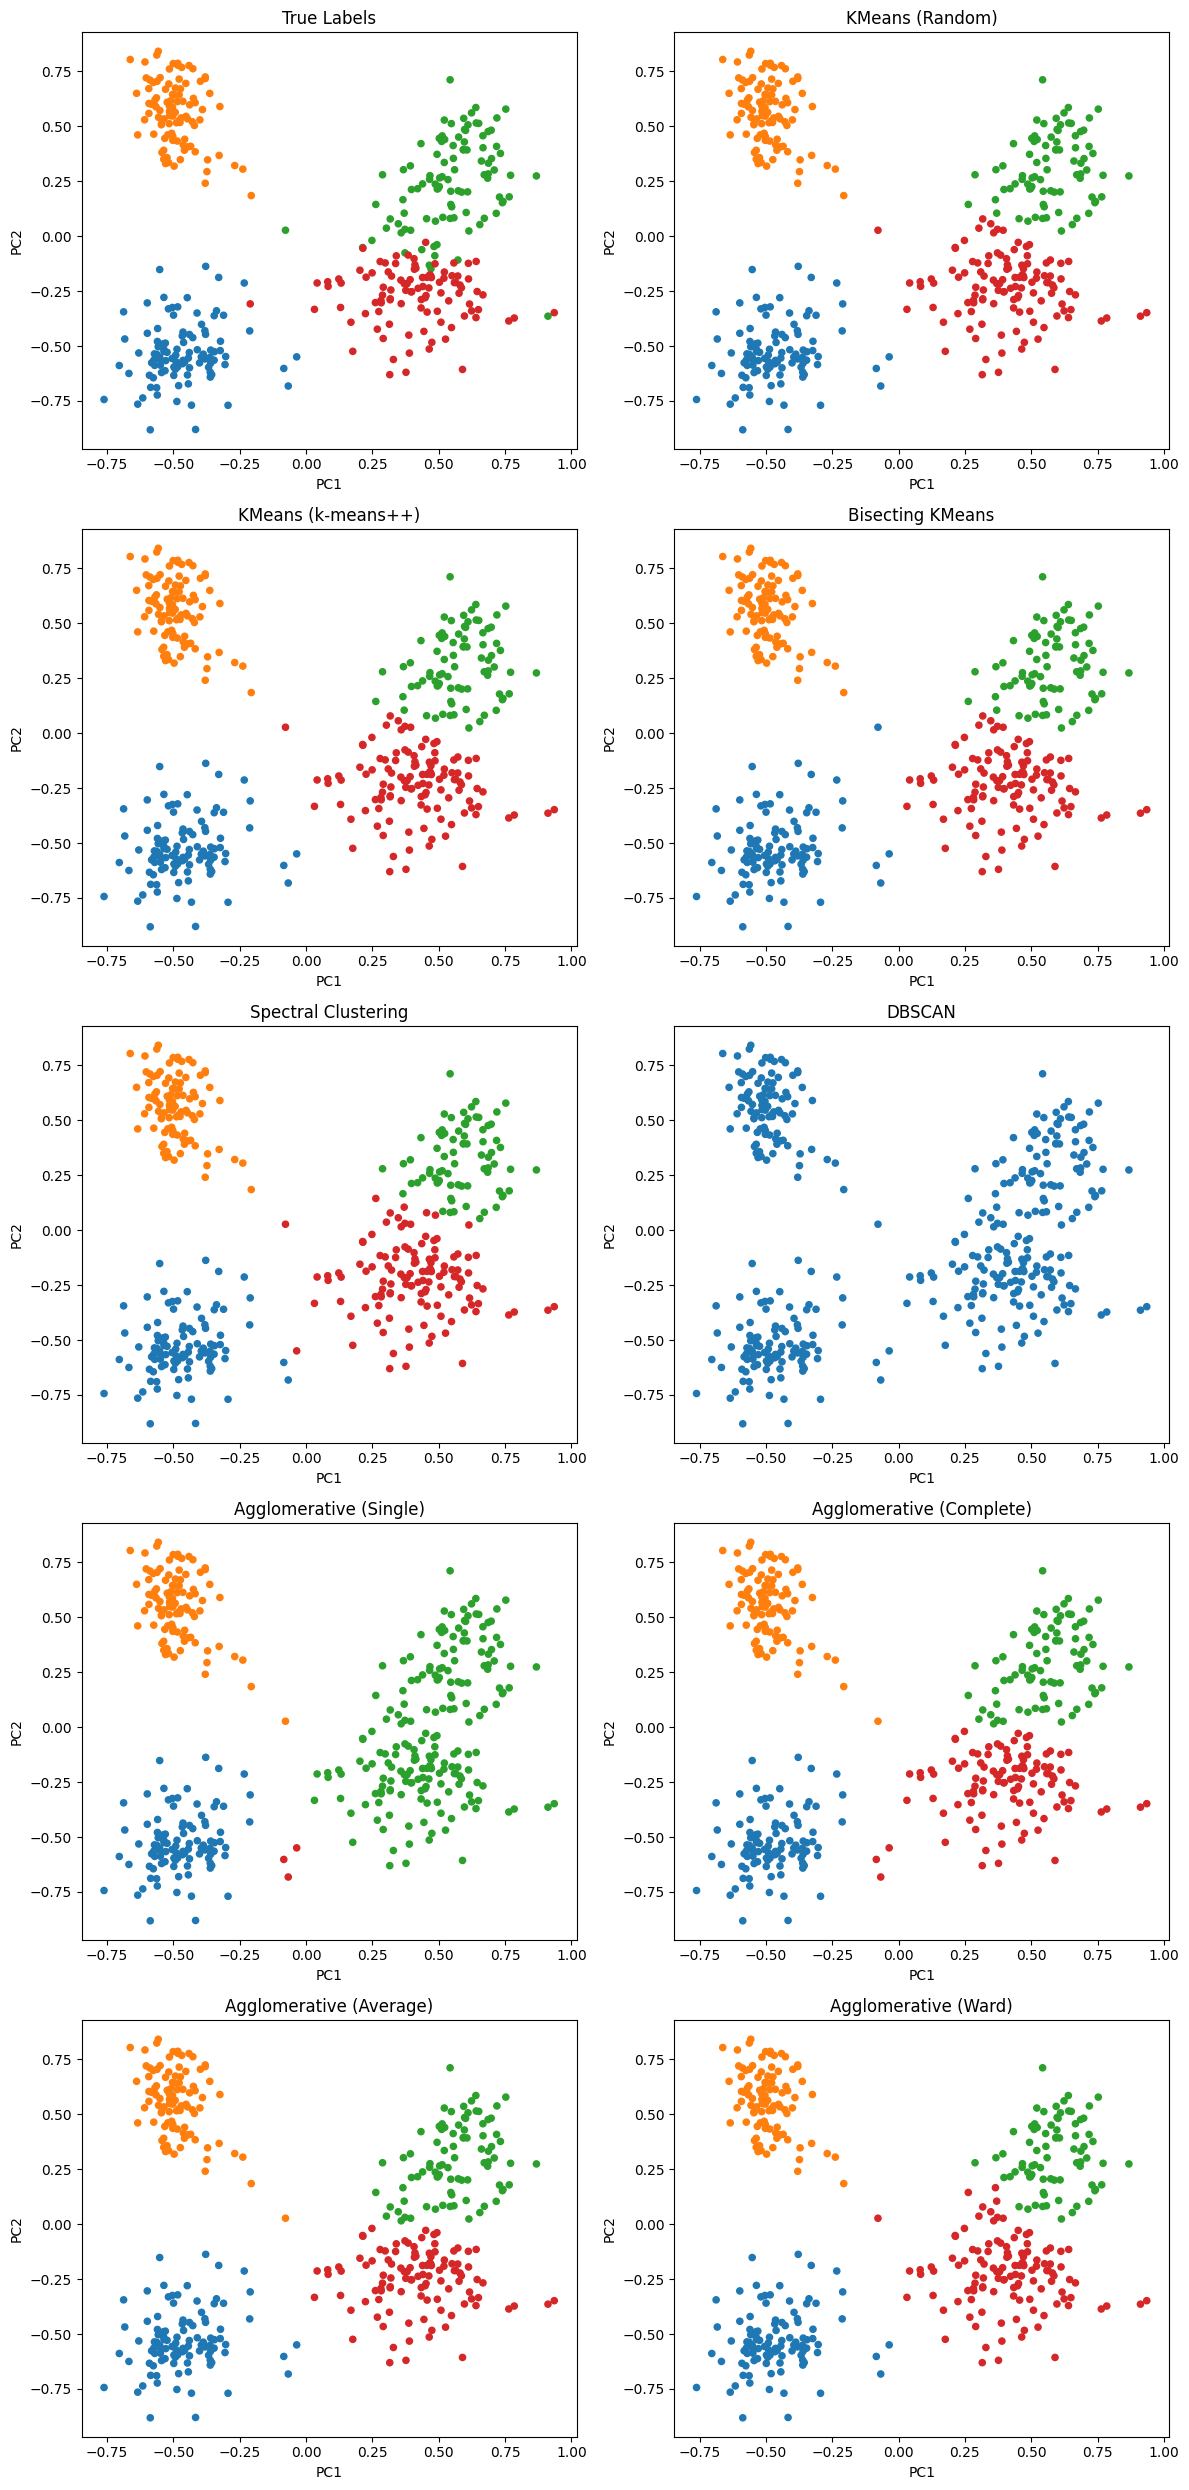

In [27]:
# Align cluster labels + Plot all clustering methods with same colors

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

# Function to align predicted labels to true labels
def align_labels_to_true(y_true, y_pred, n_classes=4):
    new_labels = np.full_like(y_pred, fill_value=-1)
    mask = (y_pred != -1)
    if mask.sum() == 0:
        return y_pred.copy()

    cm = contingency_matrix(y_true[mask], y_pred[mask])
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col_ind[j]: row_ind[j] for j in range(len(row_ind))}

    for old_lbl, new_lbl in mapping.items():
        new_labels[y_pred == old_lbl] = new_lbl

    return new_labels

# Align labels for all clustering methods
aligned_cluster_results = {}
for name, labels in cluster_results.items():
    aligned_cluster_results[name] = align_labels_to_true(y_true, labels, n_classes=4)

# Plotting settings
color_list = np.array(["tab:blue", "tab:orange", "tab:green", "tab:red", "gray"])

titles = [
    "True Labels",
    "KMeans (Random)",
    "KMeans (k-means++)",
    "Bisecting KMeans",
    "Spectral Clustering",
    "DBSCAN",
    "Agglomerative (Single)",
    "Agglomerative (Complete)",
    "Agglomerative (Average)",
    "Agglomerative (Ward)"
]

plot_data = [
    y_true,
    aligned_cluster_results["kmeans_random"],
    aligned_cluster_results["kmeans_plus"],
    aligned_cluster_results["bisect_kmeans"],
    aligned_cluster_results["spectral"],
    aligned_cluster_results["dbscan"],
    aligned_cluster_results["agg_single"],
    aligned_cluster_results["agg_complete"],
    aligned_cluster_results["agg_average"],
    aligned_cluster_results["agg_ward"],
]

# Plot all methods with consistent color labels
fig, axes = plt.subplots(5, 2, figsize=(12, 25))
axes = axes.flatten()

for i, ax in enumerate(axes):
    labels = plot_data[i]
    label_idx = np.where(labels == -1, 4, labels)  # noise -> gray
    colors = color_list[label_idx]

    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=20)
    ax.set_title(titles[i])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()


###Plot Interpretation

The PCA plots show four clear groups in the dataset. When I compare the true labels with the clustering results, I can see that KMeans (both versions), Bisecting KMeans, Spectral Clustering, and most Agglomerative methods recreate these four clusters in almost the same positions.

Single linkage does not separate the groups well, and DBSCAN fails to form four clusters because many points are treated as noise. Overall, the plots show that most methods correctly captured the 4-class structure.